In [1]:
%matplotlib inline 

from imports import *

print('cuda' if torch.cuda.is_available() else 'cpu')

cpu


In [2]:
params = create_problem('./data/Set12/13.jpg')

/home/abhiram/.local/lib/python3.8/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


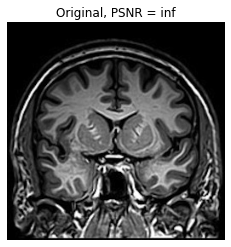

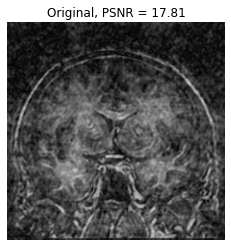

In [3]:
psnr_display('./data/Set12/13.jpg', params['original'], "Original")

psnr_display('./data/Set12/13.jpg', params['noisy'], "Original")

In [ ]:
T1 = list(np.arange(0, 45, 5)[1:])
T2 = list(np.arange(0, 45, 5)[1:])
eta = list(np.arange(0.01, 0.1, 0.01))
# batch = list(range(10, 500, 100))
iters = list(product(T1, T2, eta))


'''
during cross-validation, only consider testing when T1 >= T2
'''
# pruned = []

# for each in iters:
#     if each[0] >= each[1]:
#         pruned.append(each)

In [ ]:
def f(iters):
    return peak_signal_noise_ratio(original, pnp_svrg(params=params,
                                                      denoiser='cnn'
                                                      eta=iters[2], T1=iters[0], T2=iters[1], 
                                                      mini_batch_size=200)[0])

with MP.Pool(processes=5) as pool:
    results = list(tqdm.tqdm(pool.imap(f, pruned), total=len(pruned)))

In [ ]:
max(results), pruned[results.index(max(results))]

In [ ]:
svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_svrg(params=params,
                                                   denoiser='nlm',
                                                   eta=100, T1=20, T2=100, mini_batch_size=500)
psnr_display('./data/Set12/13.jpg', svrg_out, "SVRG")

In [ ]:
svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_svrg(params=params,
                                                   denoiser='cnn',
                                                   eta=0.01, T1=20, T2=100, mini_batch_size=300)
psnr_display('./data/Set12/13.jpg', svrg_out, "SVRG")

In [ ]:
import ffmpeg
gif(zs)